In [2]:
# NYC Taxi Analysis

## Goal of the Project:

### Analyze the peak times for taxi that will help drivers to maximize their income
### Undertand didderent factors that influence taking taxis like weather conditions, seasons, etc.

#### We will import total 3 files for our analysis for the year 2022

### 1. NYC TLC Dataset
### 2. Taxi Zone Dataset
### 3. NYC Weather report 

In [3]:
from os.path import getsize
from urllib.request import urlretrieve

In [4]:
# Output directory
output_dir = "..r/Summer_2023/NYC_taxi_analysis"

## download 2018 yellow taxi trip data
# fname = "yellow_tripdata_2018"

## change range(x, y) to be the months you want
# for m in list([1, 2, 7, 8]):
#     month = str(m).zfill(2)
#     out = f'{fname}-{month}.csv'
#     temp = f'{"yellow_2018"}_{month}.csv'
#     url = f"https://s3.amazonaws.com/nyc-tlc/trip+data/{out}"
#     urlretrieve(url, f"{output_dir}/{temp}")

#     print(f"Done downloading {temp} to {output_dir} with size {getsize(f'{output_dir}/{temp}') / 1073741824:.2f}GB")

In [5]:
# I have downloaded the file directly from the website


In [6]:
# Importing libraries

import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calender
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
!pip3 install pyarrow

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [8]:
# Importing Data

file_path_01 = '.../Summer_2023/NYC_taxi_analysis/raw_data/yellow_tripdata_2022-01.parquet'
file_path_02 = '.../NYC_taxi_analysis/raw_data/yellow_tripdata_2022-02.parquet'
file_path_07 = '.../Summer_2023/NYC_taxi_analysis/raw_data/yellow_tripdata_2022-07.parquet'
file_path_08 = '.../Summer_2023/NYC_taxi_analysis/raw_data/yellow_tripdata_2022-08.parquet'

yellow_01 = pd.read_parquet(file_path_01)
yellow_02 = pd.read_parquet(file_path_02)
yellow_07 = pd.read_parquet(file_path_07)
yellow_08 = pd.read_parquet(file_path_08)


   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2022-01-01 00:35:40   2022-01-01 00:53:29              2.0   
1         1  2022-01-01 00:33:43   2022-01-01 00:42:07              1.0   
2         2  2022-01-01 00:53:21   2022-01-01 01:02:19              1.0   
3         2  2022-01-01 00:25:21   2022-01-01 00:35:23              1.0   
4         2  2022-01-01 00:36:48   2022-01-01 01:14:20              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.80         1.0                  N           142           236   
1           2.10         1.0                  N           236            42   
2           0.97         1.0                  N           166           166   
3           1.09         1.0                  N           114            68   
4           4.30         1.0                  N            68           163   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


In [ ]:
print(yellow_02.head())

In [ ]:
print(yellow_07.head())

In [ ]:
print(yellow_08.head())

In [12]:
yellow_01.shape

(2463931, 19)

In [13]:
## Combining the monthly data as a Season (winter and summer)

winter = pd.concat([yellow_01, yellow_02]).reset_index(drop=True)
summer = pd.concat([yellow_07, yellow_08]).reset_index(drop=True)

## labeling dataset as winter and summer

winter['season'] = 'winter'
summer['season'] = 'summer'

# remove any invalid date

winter = winter[(winter['tpep_pickup_datetime'] >= '2022-01-01 00:00:00') 
    & (winter['tpep_pickup_datetime'] <= '2022-02-28 23:59:59') 
    & (winter['tpep_dropoff_datetime'] >= '2022-01-01 00:00:00') 
    & (winter['tpep_dropoff_datetime'] <= '2022-02-28 23:59:59')]
summer = summer[(summer['tpep_pickup_datetime'] >= '2022-07-01 00:00:00') 
    & (summer['tpep_pickup_datetime'] <= '2022-08-31 23:59:59') 
    & (summer['tpep_dropoff_datetime'] >= '2022-07-01 00:00:00') 
    & (summer['tpep_dropoff_datetime'] <= '2022-08-31 23:59:59')]

# Merging 
data = pd.concat([winter, summer]).reset_index(drop=True)

In [14]:
winter.shape

(5442763, 20)

In [15]:
summer.shape

(6326013, 20)

In [16]:
data.shape # 11M * 20 

(11768776, 20)

In [ ]:
data.head(n=5)

In [18]:
###### Feature Engineering #######

In [19]:
## 1. Calculate duration of the trip and holidays

# We will calculate the duration of the trips. In order to calculate the duration we will first extract 
# day and time and then subtract drop off time from pickup time

In [20]:
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

In [21]:
# Normalize function will normalize times to midnight yielding only date in 'date' column

data['date'] = data['tpep_pickup_datetime'].dt.normalize()
data['time'] = data['tpep_pickup_datetime'].dt.hour            # extracts hour component from datetime
data['weekday'] = data['date'].dt.day_name()                   # extracts weekday from datetime
data['duration'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime'] # Duration = dropoff - pickup
data['duration'] = data['duration'] / np.timedelta64(1, 'm')   # converting duration to minutes

In [ ]:
data.head(n=5)

In [23]:
# Since our one of the goals in the analysis is to look the peak times in workdays and holidays, we will
# create new columns that will help in distinguishing them

In [24]:
# Identifying holidays, weekend and workdays

cal = calender()
holidays = cal.holidays(start='2022-01-01', end='2022-12-31') 
data['holiday'] = data['date'].isin(holidays)          # Creates a column holiday and mark holidays
data['week'] = data['date'].dt.dayofweek               # Numbers the week starting 0-Mon to 6-Sun
data.loc[data['week'] >= 5, 'day_type'] = "weekend"     
data.loc[data['week'] < 5, 'day_type'] = "workday"
data.loc[data['holiday'] == True, 'day_type'] = "holiday" # Creates a Column for day_type as weekday, holiday
data = data.drop(['holiday', 'week'], axis=1)             # drops the column holiday & week

In [25]:
data.head(n=2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,season,date,time,weekday,duration,day_type
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.8,1.0,N,142,236,1,...,0.3,21.95,2.5,0.0,winter,2022-01-01,0,Saturday,17.816667,weekend
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.1,1.0,N,236,42,1,...,0.3,13.30,0.0,0.0,winter,2022-01-01,0,Saturday,8.400000,weekend


In [26]:
# Calculating tip percentage using tip amount and total trip amount

data['tip_percent'] = (data.tip_amount / data.total_amount) * 100   # avg tip 12%


In [27]:
# Classifying trip's time slot in 4 categories: Morning, Afternoon, Evng & late night

def time_slots(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,17):
        return 'Afternoon'
    elif x in range(17,22):
        return 'Evening'
    else:
        return 'Late Night'    # Note that in range syntax the start value is inclusive but stop value is exclusive

data['time_desc'] = data['time'].apply(time_slots)

In [28]:
# Dropping features that are not useful for analysis

data = data.drop(['store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge'], axis=1)

In [29]:
data.shape

(11768776, 23)

In [30]:
# Description statistics for continuous variables
data[['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount', 'duration', 'tip_percent']].describe()

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount,duration,tip_percent
count,1.139721e+07,1.176878e+07,1.176878e+07,1.176878e+07,1.176878e+07,1.176878e+07,1.176878e+07,1.176691e+07
mean,1.409888e+00,5.701670e+00,1.397175e+01,2.566680e+00,4.737850e-01,2.050042e+01,1.599391e+01,1.197565e+01
std,9.842613e-01,5.737118e+02,1.177014e+02,3.068295e+00,1.905936e+00,1.181146e+02,4.751305e+01,8.000101e+00
min,0.000000e+00,0.000000e+00,-9.000000e+02,-1.880000e+02,-9.999000e+01,-8.953000e+02,-3.442400e+03,-5.555556e+02
25%,1.000000e+00,1.100000e+00,7.000000e+00,5.000000e-02,0.000000e+00,1.180000e+01,6.983333e+00,2.557545e-01
50%,1.000000e+00,1.860000e+00,9.500000e+00,2.060000e+00,0.000000e+00,1.535000e+01,1.140000e+01,1.660777e+01
75%,1.000000e+00,3.430000e+00,1.550000e+01,3.160000e+00,0.000000e+00,2.180000e+01,1.823333e+01,1.666667e+01
max,9.000000e+00,3.487985e+05,4.010923e+05,8.888800e+02,5.630900e+02,4.010956e+05,8.513183e+03,1.000000e+02


<AxesSubplot:xlabel='trip_distance', ylabel='Density'>

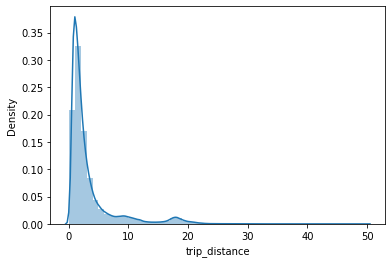

In [31]:
# Trip distance distribution
sns.distplot(data[(data['trip_distance'] > 0) & (data['trip_distance'] <= 50)]['trip_distance'])

<AxesSubplot:xlabel='duration', ylabel='Density'>

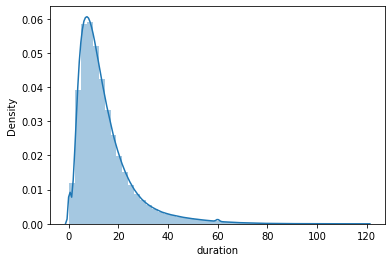

In [32]:
# Duration distribution
sns.distplot(data[(data['duration'] > 0) & (data['duration'] < 120)]['duration'])


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

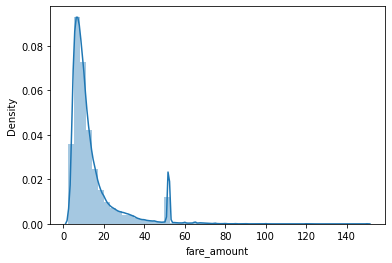

In [33]:
# Fare_amount distribution
sns.distplot(data[(data['fare_amount'] >= 2.5)&(data['fare_amount'] <= 150)]['fare_amount'])

<AxesSubplot:xlabel='tip_amount', ylabel='Density'>

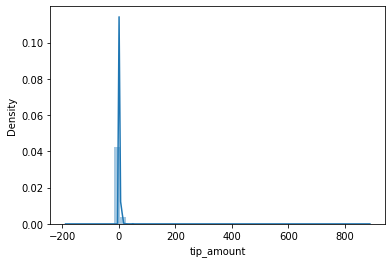

In [34]:
# Tip amount distribution
sns.distplot(data.tip_amount)

In [35]:
# remove invalid data
# passenger == 0
data = data[(data['passenger_count'] > 0) & (data['passenger_count'] < 7)]

# trip_distance <= 0
data = data[(data['trip_distance'] > 0) & (data['trip_distance'] <= 100)]

# exclude duration longer than 180 mins
data = data[(data['duration'] > 0) & (data['duration'] <= 180)]

# payment method other than cash and credit card
data = data[(data['payment_type'] != 3) & (data['payment_type'] != 4) & (data['payment_type'] != 5) & (data['payment_type'] != 6)]

# exclude instances with fare amount less than 2.5
data = data[(data['fare_amount'] >= 2.5) & (data['fare_amount'] <= 250)]

# remove trips with tip precentage over 50%
data = data[(data['tip_percent'] >= 0) & (data['tip_percent'] <= 50)]

# PU and DO location id not within NYC taxi zone
data = data[(data['PULocationID'] >= 1) & (data['PULocationID'] <= 263) & (data['DOLocationID'] >= 1) & (data['DOLocationID'] <= 263)]


In [36]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,congestion_surcharge,airport_fee,season,date,time,weekday,duration,day_type,tip_percent,time_desc
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,142,236,1,14.5,...,2.5,0.0,winter,2022-01-01,0,Saturday,17.816667,weekend,16.628702,Late Night
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,236,42,1,8.0,...,0.0,0.0,winter,2022-01-01,0,Saturday,8.400000,weekend,30.075188,Late Night
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,166,166,1,7.5,...,0.0,0.0,winter,2022-01-01,0,Saturday,8.966667,weekend,16.666667,Late Night
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,114,68,2,8.0,...,2.5,0.0,winter,2022-01-01,0,Saturday,10.033333,weekend,0.000000,Late Night
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,68,163,1,23.5,...,2.5,0.0,winter,2022-01-01,0,Saturday,37.533333,weekend,9.900990,Late Night


In [37]:
# Convert passenger counts into 3 categories: small, medium, high

def passenger_convert(y):
    if (y>=1) & (y<=2):
        val = "small"
    elif (y>2) & (y<5):
        val = "medium"
    else:
        val = "high"
    return val

data['passenger_count'] = data['passenger_count'].apply(passenger_convert)

In [38]:
data['passenger_count'].value_counts()

small     9718850
medium     649967
high       359149
Name: passenger_count, dtype: int64

In [44]:
### Preprocess external weather data

# import tabula
# pdf_file_path = '/Users/shirishpandagare/Documents/DiptiFolder/Summer_2023/NYC_taxi_analysis/raw_data/Weather-Jan-2022.pdf'

# tabula.convert_into(pdf_file_path, 'output.csv', output_format='csv')


In [ ]:
# Since the weather data of 2022 was available in PDF format on monthly basis, I have converted to excel 
# using online tools and will perform data merging and cleaning here